## Data Preparation

In [570]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import torch

from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from copy import deepcopy

In [571]:
df = pd.read_csv('AMZN.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6516 entries, 0 to 6515
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       6516 non-null   object 
 1   Open       6516 non-null   float64
 2   High       6516 non-null   float64
 3   Low        6516 non-null   float64
 4   Close      6516 non-null   float64
 5   Adj Close  6516 non-null   float64
 6   Volume     6516 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 356.5+ KB


In [572]:
# Mengecek missing value di tipe data int64 dan float64
for col in df.columns:
    if df[col].dtype == 'int64' or df[col].dtype == 'float64':
        print(col, df[col].isnull().sum())

Open 0
High 0
Low 0
Close 0
Adj Close 0
Volume 0


In [573]:
# Mengecek missing value di tipe data object
for column in df.columns:
    if df[column].dtype == object:
        print(str(column), str(df[column].isnull().sum()))

Date 0


In [574]:
# Mengambil data yang dibutuhkan
df = df[['Date', 'Close']]
df.head()

,Date,Close
0,1997-05-15,0.097917
1,1997-05-16,0.086458
2,1997-05-19,0.085417
3,1997-05-20,0.081771
4,1997-05-21,0.071354


In [575]:
# Mengecek apakah ada GPU yang tersedia
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [576]:
# Mengubah tipe data Date menjadi tipe data datetime
df['Date'] = pd.to_datetime(df['Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6516 entries, 0 to 6515
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    6516 non-null   datetime64[ns]
 1   Close   6516 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 101.9 KB


In [577]:
# Membuat plot Date dan Close
fig = go.Figure(go.Scatter(x=df['Date'], y=df['Close'], name='Close'))
fig.update_layout(showlegend=True, title='Amazon Stock Prices', xaxis_title='Date', yaxis_title='Stock Price (USD)')
fig.show()

## Prepare Data for LSTM

In [578]:
# Membuat fungsi untuk mempersiapkan data untuk LSTM
def prepare_df_for_lstm(df, n_steps):
    df = deepcopy(df)
    df.set_index('Date', inplace=True)
    
    for i in range(1, n_steps+1):
        df['Close-'+str(i)] = df['Close'].shift(i)
    
    df.dropna(inplace=True)
    return df

loocback = 7
shifted_df = prepare_df_for_lstm(df, loocback)
shifted_df.head()

,Close,Close-1,Close-2,Close-3,Close-4,Close-5,Close-6,Close-7
Date,,,,,,,,
1997-05-27,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458,0.097917
1997-05-28,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458
1997-05-29,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417
1997-05-30,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771
1997-06-02,0.075521,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354


In [579]:
# Konfersi ke dalam bentuk numpy array
shifted_df_as_np = shifted_df.to_numpy()
shifted_df_as_np

array([[7.91670000e-02, 7.50000000e-02, 6.97920000e-02, ...,
        8.54170000e-02, 8.64580000e-02, 9.79170000e-02],
       [7.65630000e-02, 7.91670000e-02, 7.50000000e-02, ...,
        8.17710000e-02, 8.54170000e-02, 8.64580000e-02],
       [7.52600000e-02, 7.65630000e-02, 7.91670000e-02, ...,
        7.13540000e-02, 8.17710000e-02, 8.54170000e-02],
       ...,
       [1.02410004e+02, 1.03290001e+02, 1.02000000e+02, ...,
        9.80400010e+01, 9.81299970e+01, 9.87099990e+01],
       [1.03949997e+02, 1.02410004e+02, 1.03290001e+02, ...,
        9.72399980e+01, 9.80400010e+01, 9.81299970e+01],
       [1.01099998e+02, 1.03949997e+02, 1.02410004e+02, ...,
        1.00250000e+02, 9.72399980e+01, 9.80400010e+01]])

In [580]:
shifted_df_as_np.shape

(6509, 8)

## Data Preprocessing and Splitting

In [581]:
# Skalar dengan range -1 sd 1
scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)
shifted_df_as_np

array([[-0.99991063, -0.99995531, -1.        , ..., -0.99983244,
        -0.99982128, -0.99969839],
       [-0.99993855, -0.99991063, -0.99994415, ..., -0.99987154,
        -0.99983244, -0.99982128],
       [-0.99995253, -0.99993855, -0.99989946, ..., -0.99998325,
        -0.99987154, -0.99983244],
       ...,
       [ 0.09747299,  0.10690997,  0.09308121, ...,  0.0506149 ,
         0.05158   ,  0.05779984],
       [ 0.11398769,  0.09747299,  0.10691495, ...,  0.04203581,
         0.0506149 ,  0.05158   ],
       [ 0.08342464,  0.11398769,  0.09747802, ...,  0.07431453,
         0.04203581,  0.0506149 ]])

In [582]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((6509, 7), (6509,))

In [583]:
# Pembalikan urutan elemen X
X = deepcopy(np.flip(X, axis=1))
X

array([[-0.99969839, -0.99982128, -0.99983244, ..., -0.99998325,
        -1.        , -0.99995531],
       [-0.99982128, -0.99983244, -0.99987154, ..., -1.        ,
        -0.99994415, -0.99991063],
       [-0.99983244, -0.99987154, -0.99998325, ..., -0.99994415,
        -0.99989946, -0.99993855],
       ...,
       [ 0.05779984,  0.05158   ,  0.0506149 , ...,  0.07431453,
         0.09308121,  0.10690997],
       [ 0.05158   ,  0.0506149 ,  0.04203581, ...,  0.09308121,
         0.10691495,  0.09747299],
       [ 0.0506149 ,  0.04203581,  0.07431453, ...,  0.10691495,
         0.09747802,  0.11398769]])

In [584]:
# Pembagian training dan testing X dan y dengan perbandingan 95:5
X_train = X[:int(X.shape[0]*0.95)]
y_train = y[:int(y.shape[0]*0.95)]
X_test = X[int(X.shape[0]*0.95):]
y_test = y[int(y.shape[0]*0.95):]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6183, 7), (6183,), (326, 7), (326,))

In [585]:
X_train = X_train.reshape((-1, loocback, 1))
X_test = X_test.reshape((-1, loocback, 1))
y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6183, 7, 1), (326, 7, 1), (6183, 1), (326, 1))

In [586]:
# Ubah ke dalam bentuk tipe data tensor
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()

## Time Series Forecasting with LSTM Neural Network Python

In [587]:
# Membuat class TimeSeriesDataset
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
train_df = TimeSeriesDataset(X_train, y_train)
test_df = TimeSeriesDataset(X_test, y_test)

In [588]:
# DataLoader untuk mengatur data dalam batch
train_loader = DataLoader(dataset=train_df, batch_size=16, shuffle=True)
test_loader = DataLoader(dataset=test_df, batch_size=16, shuffle=False)
train_loader, test_loader

(<torch.utils.data.dataloader.DataLoader at 0x2023d721af0>,
 <torch.utils.data.dataloader.DataLoader at 0x2023d721640>)

In [589]:
for _, batch in enumerate(train_loader):
    X_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(X_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [590]:
# Membuat class LSTM
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hideen_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, X):
        batch_size = X.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hideen_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hideen_size).to(device)
        out, _ = self.lstm(X, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
    
model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [591]:
def training():
    model.train(True)
    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    
    for batch_idx, batch in enumerate(train_loader):
        X_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(X_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch_idx % 100 == 99:
            avg_loss = running_loss/100
            print('Batch: ', batch_idx+1, 'Loss: ', avg_loss)
            running_loss = 0.0
    print()

In [592]:
def validate():
    model.train(False)
    running_loss = 0.0
    
    for batch_idx, batch in enumerate(test_loader):
        X_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            y_pred = model(X_batch)
            loss = loss_function(y_pred, y_batch)
            running_loss += loss.item()
        
    avg_loss = running_loss/len(test_loader)    
    print('Val Loss: ', round(avg_loss, 3))
    print('Val MSE: ', mean_squared_error(y_batch.cpu().numpy(), y_pred.cpu().numpy()))
    print('***************************************************')
    print()

In [593]:
num_epoch = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epoch):
    training()
    validate()


Epoch:  1


Batch:  100 Loss:  0.2883233205229044
Batch:  200 Loss:  0.15548283278942107
Batch:  300 Loss:  0.0690796213876456

Val Loss:  0.044
Val MSE:  0.0023099284
***************************************************

Epoch:  2
Batch:  100 Loss:  0.011573052307940089
Batch:  200 Loss:  0.006738307727500796
Batch:  300 Loss:  0.004957966016372666

Val Loss:  0.009
Val MSE:  0.0049792845
***************************************************

Epoch:  3
Batch:  100 Loss:  0.0025842552189715207
Batch:  200 Loss:  0.0016139199177268892
Batch:  300 Loss:  0.0013881255892920308

Val Loss:  0.005
Val MSE:  0.0015886392
***************************************************

Epoch:  4
Batch:  100 Loss:  0.0006466800806811079
Batch:  200 Loss:  0.0005354793141304981
Batch:  300 Loss:  0.0004058995402738219

Val Loss:  0.003
Val MSE:  0.0005025451
***************************************************

Epoch:  5
Batch:  100 Loss:  0.00029980910479935117
Batch:  200 Loss:  0.00024534755313652566
Batch:  300 Loss:  

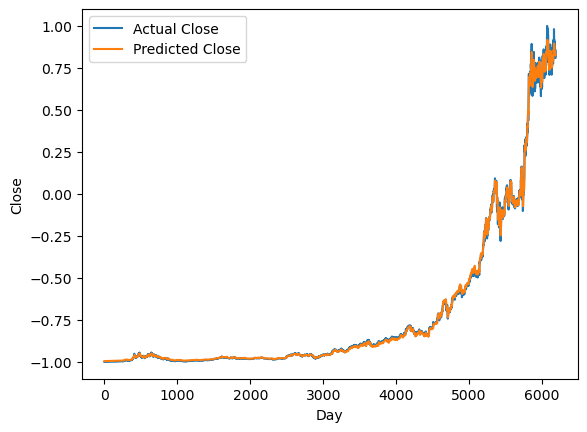

In [594]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()

## Convert and Plot to Dummy Variables

In [595]:
# Mengkonversi kembali nilai train prediksi menjadi nilai asli
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], loocback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = deepcopy(dummies[:, 0])
train_predictions, train_predictions.shape

(array([  0.54482974,   0.54422946,   0.54397379, ..., 170.79284098,
        170.08846005, 170.70466692]),
 (6183,))

In [596]:
# Mengkonversi kembali nilai train target yang telah dinormalisasi ke nilai asli
dummies = np.zeros((X_train.shape[0], loocback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = deepcopy(dummies[:, 0])
new_y_train

array([7.91646265e-02, 7.65634249e-02, 7.52572660e-02, ...,
       1.69091505e+02, 1.73315001e+02, 1.68871003e+02])

In [597]:
# Mengkonversi kembali nilai test prediksi menjadi nilai asli
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], loocback+1))
dummies[:, 0] = test_predictions
test_predictions = scaler.inverse_transform(dummies)

test_predictions = deepcopy(test_predictions[:, 0])
test_predictions

array([169.81145431, 169.57507845, 168.64684966, 168.99566635,
       169.38942602, 169.64316546, 169.38982621, 169.56746382,
       169.27231637, 168.97595725, 168.21151523, 168.72180651,
       168.23105759, 167.06678643, 165.99986024, 165.1096379 ,
       164.20735443, 164.76694626, 165.00418919, 164.04674691,
       163.77417655, 162.6365288 , 161.0954169 , 158.60128698,
       153.79805706, 151.21287397, 147.84836421, 145.1820881 ,
       143.77927341, 144.54658342, 147.16967291, 149.59734991,
       150.98673617, 147.82121833, 152.26867279, 155.14506819,
       158.03887162, 159.78410004, 160.25147149, 158.79812235,
       158.58625781, 158.54641719, 158.99519116, 158.14445373,
       156.95045773, 155.40656676, 152.60563956, 152.95365588,
       153.95029405, 154.52280296, 154.18122295, 154.31361744,
       153.02614492, 151.4467709 , 147.30046666, 143.9007184 ,
       142.86277227, 145.02576033, 146.02675606, 145.47846945,
       147.15473268, 150.33367894, 153.7683211 , 157.20

In [598]:
# Mengkonversi kembali nilai test target yang telah dinormalisasi ke nilai aslinya
dummies = np.zeros((X_test.shape[0], loocback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = deepcopy(dummies[:, 0])
new_y_test, new_y_test.shape

(array([170.01749949, 167.07899763, 170.41700626, 171.03700377,
        171.0684961 , 169.66949429, 170.66099675, 169.20100565,
        168.64449858, 166.71699707, 170.40449492, 167.52200227,
        164.35699578, 163.25399737, 162.55400179, 161.48599177,
        165.36199892, 165.20699954, 161.21400501, 162.13799851,
        158.91749416, 156.29899568, 151.66749509, 142.64300408,
        144.54400445, 139.98599336, 138.87249844, 139.63749627,
        143.97799855, 149.57350001, 151.19349835, 150.61250219,
        138.84550541, 157.63949825, 157.93550165, 161.41349717,
        161.18949925, 159.003495  , 153.29350176, 155.1670061 ,
        156.51049894, 158.10049453, 154.6524962 , 152.60149876,
        150.19749381, 144.82699629, 151.35800212, 153.78849709,
        153.56300403, 151.14199678, 152.05250627, 147.89849848,
        145.64100565, 137.45300383, 136.01449488, 139.27900567,
        146.81750468, 145.52450739, 141.8529947 , 147.36650272,
        153.10400311, 157.23899657, 161.

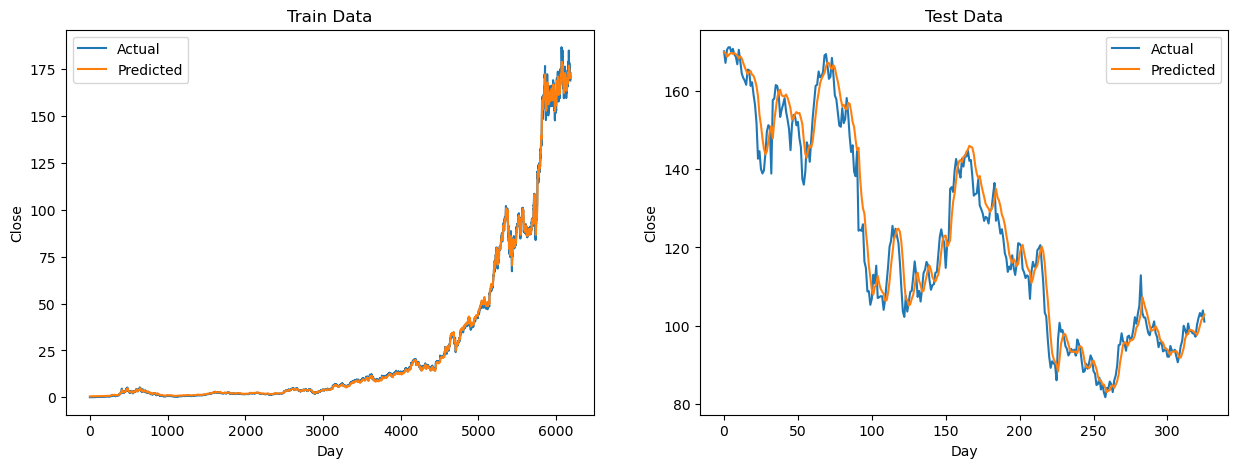

In [599]:
# Plot train dan test Actual vs Predicted
fig, ax = plt.subplots(1, 2, figsize=(15,5))

ax[0].plot(new_y_train, label='Actual')
ax[0].plot(train_predictions, label='Predicted')
ax[0].set_title('Train Data')
ax[0].set_xlabel('Day')
ax[0].set_ylabel('Close')
ax[0].legend()

ax[1].plot(new_y_test, label='Actual')
ax[1].plot(test_predictions, label='Predicted')
ax[1].set_title('Test Data')
ax[1].set_xlabel('Day')
ax[1].set_ylabel('Close')
ax[1].legend()